In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("tensorflow version :{}".format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tensorflow version :2.13.0
Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11176596140804559000
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14357954560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15263690148448022825
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
#### physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

In [ ]:
from keras.layers import Conv1D, Dense, Dropout, GlobalMaxPool1D, MaxPool1D
from keras.layers import TimeDistributed, LSTM, Bidirectional, Input, concatenate,RepeatVector
from keras import regularizers
# from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from keras.regularizers import l1,l2
from statsmodels.tsa.stattools import adfuller

In [ ]:
data_path = '/content/drive/MyDrive/CAV/data/Instant attack/100/'

In [ ]:
sensor1_data = pd.read_csv(data_path + "Sensor1_values_instant_100.csv",index_col= 'Unnamed: 0')
sensor1_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
len(sensor1_data)

29800

In [ ]:
sensor1_label = pd.read_csv(data_path+"Ground_truth_instant_100_sensor1.csv", names=['Class'])
sensor1_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
len(sensor1_label)

29800

In [ ]:
sensor2_data = pd.read_csv(data_path + "Sensor2_values_instant_100.csv", index_col = "Unnamed: 0")
sensor2_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor2_label = pd.read_csv(data_path + "Ground_truth_instant_100_sensor2.csv",names=['Class'])
sensor2_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor3_data = pd.read_csv(data_path + "Sensor3_values_instant_100.csv", index_col = "Unnamed: 0")
sensor3_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor3_label = pd.read_csv(data_path + "Ground_truth_instant_100_sensor3.csv", names=['Class'])
sensor3_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor1_data['minus_speed'] = sensor1_data['InVehicle_Longitudinal_Speed']-sensor1_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor1_data['minus_acc'] = sensor1_data['InVehicle_Longitudinal_Accel']-sensor1_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor1_data['minus_Gps'] = sensor1_data['GPS_Speed']-sensor1_data['GPS_Speed'].shift(1)


In [ ]:
sensor2_data['minus_speed'] = sensor2_data['InVehicle_Longitudinal_Speed']-sensor2_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor2_data['minus_acc'] = sensor2_data['InVehicle_Longitudinal_Accel']-sensor2_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor2_data['minus_Gps'] = sensor2_data['GPS_Speed']-sensor2_data['GPS_Speed'].shift(1)


In [ ]:
sensor3_data['minus_speed'] = sensor3_data['InVehicle_Longitudinal_Speed']-sensor3_data['InVehicle_Longitudinal_Speed'].shift(1)
sensor3_data['minus_acc'] = sensor3_data['InVehicle_Longitudinal_Accel']-sensor3_data['InVehicle_Longitudinal_Accel'].shift(1)
sensor3_data['minus_Gps'] = sensor3_data['GPS_Speed']-sensor3_data['GPS_Speed'].shift(1)


In [ ]:
sensor1_data.dropna(inplace= True)
sensor2_data.dropna(inplace= True)
sensor3_data.dropna(inplace= True)


array([<Axes: >, <Axes: >], dtype=object)

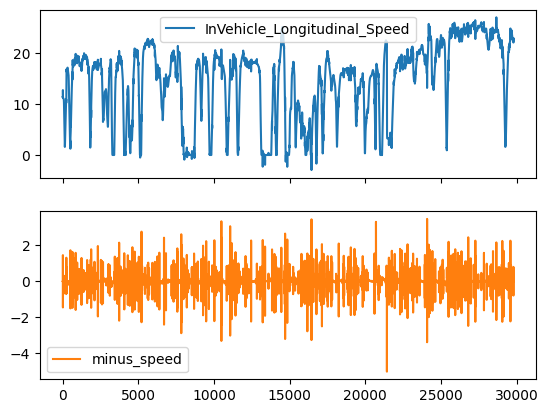

In [ ]:
sensor1_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

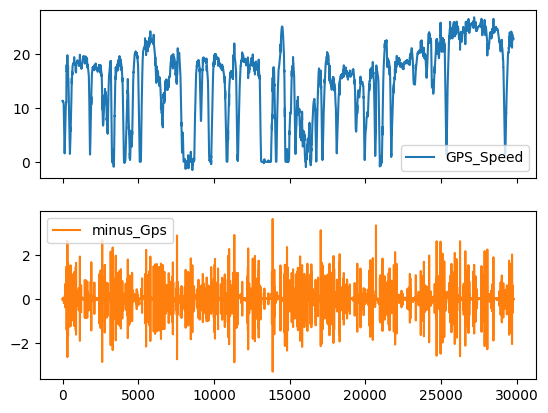

In [ ]:
sensor1_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

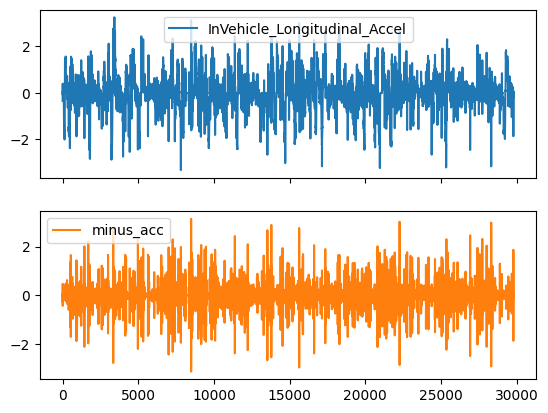

In [ ]:
sensor1_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor1_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor1_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor1_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 2.2999796776082824e-30
stationary_gps :2.5990427874052914e-29
stationary_acc :0.0



array([<Axes: >, <Axes: >], dtype=object)

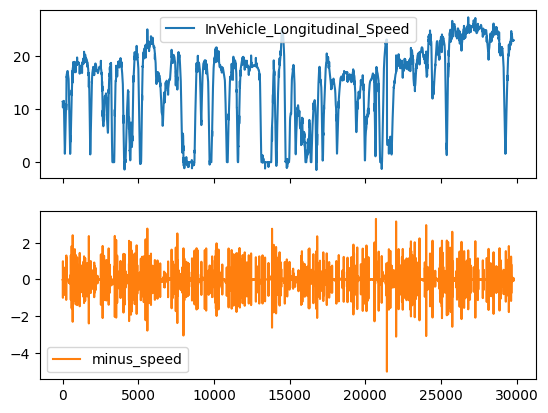

In [ ]:
sensor2_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

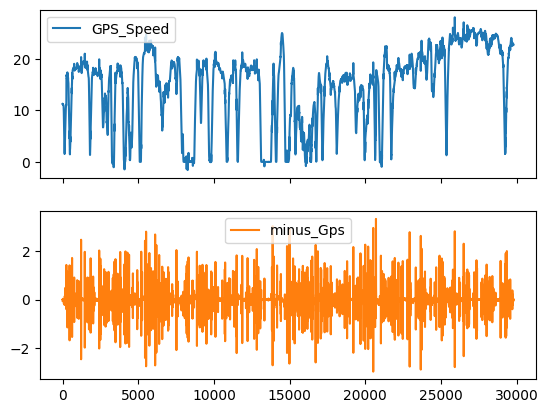

In [ ]:
sensor2_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

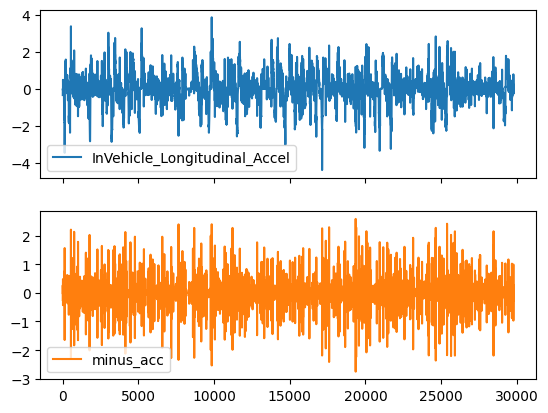

In [ ]:
sensor2_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor2_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor2_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor2_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 3.47467340351075e-30
stationary_gps :1.1326206681636829e-29
stationary_acc :0.0



array([<Axes: >, <Axes: >], dtype=object)

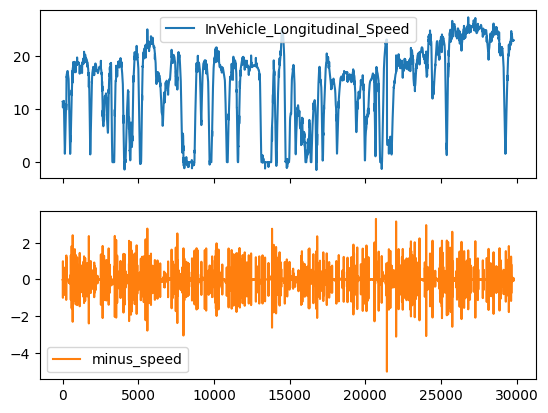

In [ ]:
sensor3_data[['InVehicle_Longitudinal_Speed','minus_speed']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

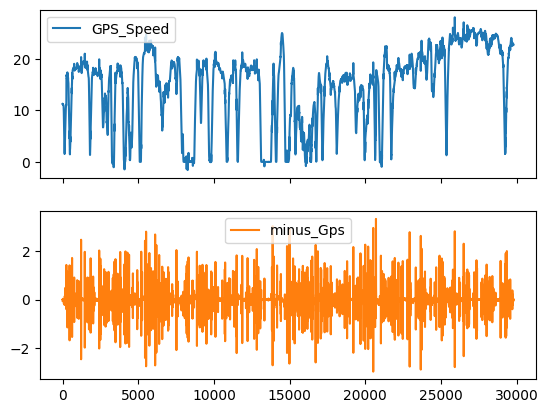

In [ ]:
sensor3_data[['GPS_Speed','minus_Gps']].plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

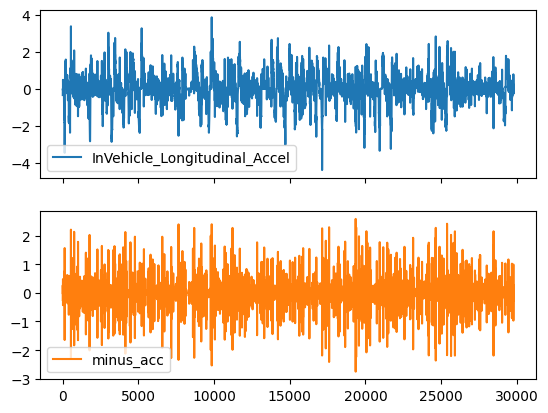

In [ ]:
sensor3_data[['InVehicle_Longitudinal_Accel','minus_acc']].plot(subplots=True)

In [ ]:
stationary_speed = adfuller(sensor3_data['minus_speed'].dropna())
stationary_gps = adfuller(sensor3_data['minus_Gps'].dropna())
stationary_acc = adfuller(sensor3_data['minus_acc'].dropna())
print("stationary_speed : {}\nstationary_gps :{}\nstationary_acc :{}\n".format(stationary_speed[1],stationary_gps[1], stationary_acc[1]))

stationary_speed : 3.47467340351075e-30
stationary_gps :1.1326206681636829e-29
stationary_acc :0.0



In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor1_data[['minus_speed','minus_Gps','minus_acc']])
sensor1_data_normal = scaler.transform(sensor1_data[['minus_speed','minus_Gps','minus_acc']])
sensor1_data_normal[:5]

array([[-0.0419842 , -0.25962499, -1.19239405],
       [-0.0230446 , -0.03645437,  1.24955065],
       [-0.01960529,  0.0694399 ,  0.22563698],
       [-0.01115401,  0.03374336,  0.02797158],
       [-0.00760226, -0.07661221, -0.01027172]])

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor2_data[['minus_speed','minus_Gps','minus_acc']])
sensor2_data_normal = scaler.transform(sensor2_data[['minus_speed','minus_Gps','minus_acc']])
sensor2_data_normal[:5]

array([[-0.04217353, -0.26130327, -1.238881  ],
       [-0.02314852, -0.03669002,  1.29826593],
       [-0.01969371,  0.06988878,  0.23443371],
       [-0.01120431,  0.03396149,  0.02906208],
       [-0.00763654, -0.07710744, -0.01067217]])

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor3_data[['minus_speed','minus_Gps','minus_acc']])
sensor3_data_normal = scaler.transform(sensor3_data[['minus_speed','minus_Gps','minus_acc']])
sensor3_data_normal[:5]

array([[-0.04217353, -0.26130327, -1.238881  ],
       [-0.02314852, -0.03669002,  1.29826593],
       [-0.01969371,  0.06988878,  0.23443371],
       [-0.01120431,  0.03396149,  0.02906208],
       [-0.00763654, -0.07710744, -0.01067217]])

In [ ]:
window_size = 10

# create windows with overlap
def convertToFrames(X_data,y_data, step):
    X, Y =[], []
    for i in range(len(X_data)-step):
        y_or = 0
        d=i+step
        X.append(X_data[i:d,])
        for y in y_data.iloc[i:d].values:
           y_or = y_or or y

        Y.append(y_or)
    return np.array(X), np.array(Y)

In [ ]:
X_sensor1, y_sensor1 = convertToFrames(sensor1_data_normal, sensor1_label, window_size)
X_sensor1.shape, y_sensor1.shape
# print(X_sensor1[0])
# print(X_sensor1[1])

((29789, 10, 3), (29789, 1))

In [ ]:
X_sensor2, y_sensor2 = convertToFrames(sensor2_data_normal, sensor2_label, window_size)
X_sensor2.shape, y_sensor2.shape

((29789, 10, 3), (29789, 1))

In [ ]:
X_sensor3, y_sensor3 = convertToFrames(sensor3_data_normal, sensor3_label, window_size)
X_sensor3.shape, y_sensor3.shape

((29789, 10, 3), (29789, 1))

In [ ]:
y_sensors = []
for i in range(len(y_sensor1)):
  y_sensors.append(y_sensor1[i] or y_sensor2[i] or y_sensor3[i])

In [ ]:
y_sensors = to_categorical(y_sensors, num_classes= 2, dtype='float32')
y_sensors.shape

(29789, 2)

In [ ]:
X_sensors = np.concatenate((X_sensor1,X_sensor2,X_sensor3),axis=1)
X_sensors.shape

(29789, 30, 3)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tscv.split(X_sensors):
    # Split the data based on the indices
    X_train_sensors, X_test_sensors = X_sensors[train_index], X_sensors[test_index]
    y_train_sensors, y_test_sensors = y_sensors[train_index], y_sensors[test_index]


In [ ]:
X_train_sensors.shape, X_test_sensors.shape, y_train_sensors.shape, y_test_sensors.shape

((27081, 30, 3), (2708, 30, 3), (27081, 2), (2708, 2))

In [ ]:

def creatModel():

    model = Sequential()
    model.add(Conv1D(kernel_size=3, filters= 40, activation= 'relu', padding='same'))
    model.add(Dropout(0.1))
    model.add( Conv1D(kernel_size=3, filters= 60, activation= 'relu', padding='same'))
    model.add(Dropout(0.1))
    model.add(Conv1D(kernel_size=3, filters= 60, activation= 'relu', padding='same'))
    model.add(Dropout(0.1))
    model.add(GlobalMaxPool1D())
    model.add(RepeatVector(X_train_sensors.shape[1]))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(rate=0.2))
    model.add((Dense(32)))
    model.add((Dense(16)))
    model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2()))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

    return model


In [ ]:
import time

class TimeHistory(Callback):

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        epoch_time = time.time() - self.epoch_time_start
        logs['epoch_time'] = epoch_time


In [ ]:
model_path = '/content/drive/MyDrive/CAV/data/Instant attack/100/Models/'

class Model_save(Callback):
  def on_epoch_end(self, epoch, logs={}):
    self.model.save(model_path + "CNN-LSTM-autoEncoder-Instant-100-CAV-perEpoch_{}.h5".format(sensor))


In [ ]:
def setCallbacks(sensor):

  best_model_path = model_path + 'Best_CNN-LSTM-autoEncoder-Instant-100-CAV_{}.h5'.format(sensor)
  checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

  history_cb = tf.keras.callbacks.CSVLogger(model_path + 'historyLOG_Instant-100_{}.csv'.format(sensor), separator=",", append=True)

  model_save = Model_save()

  Estop = EarlyStopping(monitor='val_accuracy', patience= 100)

  return model_save, checkpoint, history_cb, Estop

In [ ]:
sensor = "sensors"
time_callback = TimeHistory()
model_sensors = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensors")
history_sensors = model_sensors.fit(X_train_sensors, y_train_sensors,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#


Epoch 1/500
191/191 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 0.9323

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 23s 23ms/step - loss: 0.2247 - accuracy: 0.9323 - val_loss: 0.1186 - val_accuracy: 0.9612 - epoch_time: 22.6365
Epoch 2/500
191/191 [==============================] - 3s 16ms/step - loss: 0.1238 - accuracy: 0.9618 - val_loss: 0.1027 - val_accuracy: 0.9727 - epoch_time: 2.8474
Epoch 3/500
191/191 [==============================] - 3s 16ms/step - loss: 0.0933 - accuracy: 0.9709 - val_loss: 0.1030 - val_accuracy: 0.9623 - epoch_time: 2.8760
Epoch 4/500
191/191 [==============================] - 3s 14ms/step - loss: 0.0788 - accuracy: 0.9737 - val_loss: 0.0668 - val_accuracy: 0.9808 - epoch_time: 2.4674
Epoch 5/500
191/191 [==============================] - 3s 14ms/step - loss: 0.0692 - accuracy: 0.9769 - val_loss: 0.0608 - val_accuracy: 0.9815 - epoch_time: 2.4489
Epoch 6/500
191/191 [==============================] - 3s 14ms/step - loss: 0.0623 - accuracy: 0.9784 - val_loss: 0.0705 - val_accuracy: 0.9745 - epoch_time: 2.5006
Epoch 7/500
191/191 

In [ ]:
print(model_sensors.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 40)            400       
                                                                 
 dropout (Dropout)           (None, 30, 40)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 60)            7260      
                                                                 
 dropout_1 (Dropout)         (None, 30, 60)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 60)            10860     
                                                                 
 dropout_2 (Dropout)         (None, 30, 60)            0         
                                                                 
 global_max_pooling1d (Glob  (None, 60)                0

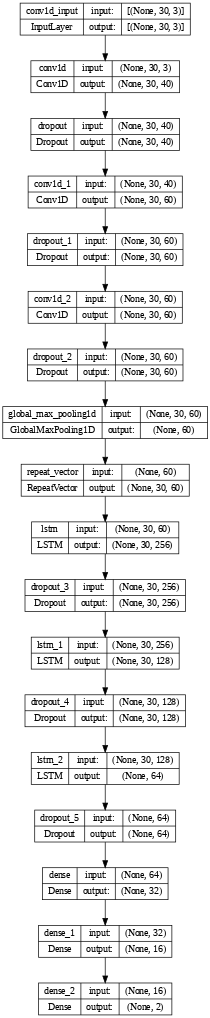

In [ ]:
plot_model(model= model_sensors, show_shapes= True, dpi=50)

In [ ]:
#plot history of model_sensor1
history_sensors = pd.read_csv(model_path +"historyLOG_Instant-100_sensors.csv", index_col='epoch')
history_sensors.reset_index(drop= True, inplace= True)
history_sensors.head()
print('Average Exe_time for sensors: {} sec.'.format(round(np.mean(history_sensors['epoch_time'].values),3)))


Average Exe_time for sensors: 2.883 sec.


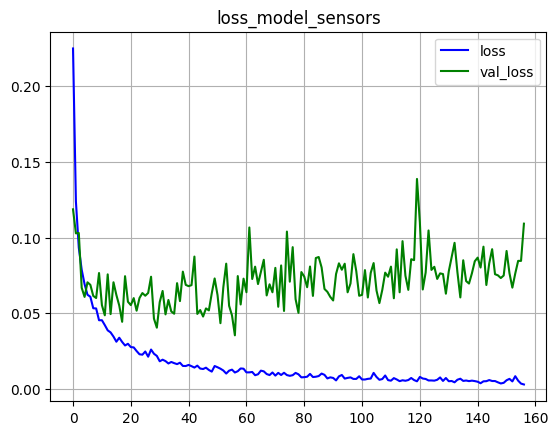

In [ ]:
plt.plot( history_sensors['loss'], 'b',label = 'loss')
plt.plot( history_sensors['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensors')
plt.show()

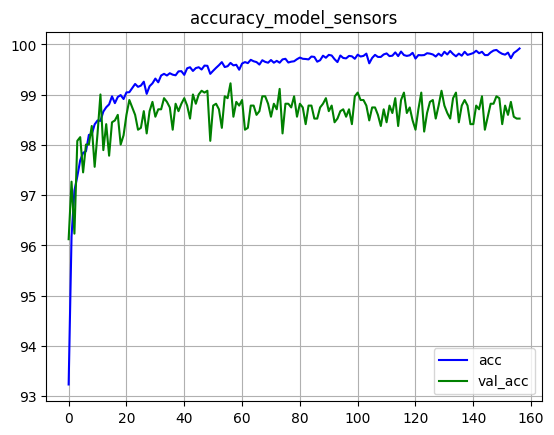

In [ ]:
plt.plot(history_sensors['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensors['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensors')
plt.show()

In [ ]:
#last model_sensor1 evaluation
test_loss, test_acc = model_sensors.evaluate( X_test_sensors, y_test_sensors, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 1s 7ms/step - loss: 0.1328 - accuracy: 0.9838
test accuracy :98.4% 
 test loss :0.133


In [ ]:
y_pred_sensors = model_sensors.predict( X_test_sensors, verbose= 1)


85/85 [==============================] - 1s 4ms/step


In [ ]:
y_pred_sensors = [np.argmax(i) for i in y_pred_sensors]


In [ ]:
y_test_sensors = [np.argmax(i) for i in y_test_sensors]


In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_sensors, y_pred_sensors, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensors, y_pred_sensors, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensors, y_pred_sensors, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensors, y_pred_sensors)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 98.38%

precision score: 98.38%

F1 score: 98.38%

accuracy score: 98.38%



In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_sensors, y_pred_sensors, average='macro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensors, y_pred_sensors, average='macro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensors, y_pred_sensors, average='macro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensors, y_pred_sensors)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 97.97%

precision score: 98.57%

F1 score: 98.26%

accuracy score: 98.38%



In [ ]:
conf = confusion_matrix(y_test_sensors, y_pred_sensors, labels=[1,0])
conf_df = pd.DataFrame(conf, columns= [1,0], index= [1,0])
conf_df

,1,0
1,978,37
0,7,1686
